In [1]:
%matplotlib inline

In [2]:
import astra
import numpy as np
import pylab as plt
import os
import glob

import matplotlib
font = {'size'   : 18}
matplotlib.rc('font', **font)

In [3]:
from scipy.signal import medfilt

In [4]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = unicode(index or '?')

In [5]:
def images_diff(im1, im2):
    assert(im1.shape==im2.shape)
    rec_diff = np.zeros(shape=(im1.shape[0],im1.shape[1],3), dtype='float32')
    im1_t = im1.copy()
    im1_t = (im1_t-im1_t.min())/(im1_t.max()-im1_t.min())
    
    im2_t = im2.copy()
    im2_t = (im2_t-im2_t.min())/(im2_t.max()-im2_t.min())
    
    # nrecon_rec_t[nrecon_rec_t<0] = 0
    diff_rec = im1_t-im2_t
    rec_diff[...,0] = diff_rec*(diff_rec>0)
    rec_diff[...,1] = -diff_rec*(diff_rec<0)
    rec_diff[...,2] = rec_diff[...,1]
    return rec_diff

In [10]:
!ls /home/makov/diskmnt/big/yaivan/Sand/_tmp/nrecon/bh*

/home/makov/diskmnt/big/yaivan/Sand/_tmp/nrecon/bh_0_rc_0:
Chieftain_Unc_2.8__pp1.tif	Chieftain_Unc_2.8__rec_spr.bmp
Chieftain_Unc_2.8__pp2.tif	Chieftain_Unc_2.8__sino0980.tif
Chieftain_Unc_2.8__rec0980.png	Chieftain_Unc_2.8__sinoraw_0980.tif
Chieftain_Unc_2.8__rec.log	tomo_config.log

/home/makov/diskmnt/big/yaivan/Sand/_tmp/nrecon/bh_0_rc_10:
Chieftain_Unc_2.8__pp1.tif	Chieftain_Unc_2.8__rec_spr.bmp
Chieftain_Unc_2.8__pp2.tif	Chieftain_Unc_2.8__sino0980.tif
Chieftain_Unc_2.8__rec0980.png	Chieftain_Unc_2.8__sinoraw_0980.tif
Chieftain_Unc_2.8__rec.log	tomo_config.log

/home/makov/diskmnt/big/yaivan/Sand/_tmp/nrecon/bh_0_rc_15:
Chieftain_Unc_2.8__pp1.tif	Chieftain_Unc_2.8__rec_spr.bmp
Chieftain_Unc_2.8__pp2.tif	Chieftain_Unc_2.8__sino0980.tif
Chieftain_Unc_2.8__rec0980.png	Chieftain_Unc_2.8__sinoraw_0980.tif
Chieftain_Unc_2.8__rec.log	tomo_config.log

/home/makov/diskmnt/big/yaivan/Sand/_tmp/nrecon/bh_0_rc_20:
Chieftain_Unc_2.8__pp1.tif	Chieftain_Unc_2.8__rec_spr.bmp
Chieftain_Unc_2.8__

In [30]:
!ls /home/makov/diskmnt/big/yaivan/MMC_1/_tmp/nrecon/bh_0_rc_0/

MMC1_2.82um__pp1.tif	  MMC1_2.82um__rec_spr.bmp
MMC1_2.82um__pp2.tif	  MMC1_2.82um__sino0960.tif
MMC1_2.82um__rec0960.png  MMC1_2.82um__sinoraw_0960.tif
MMC1_2.82um__rec.log	  tomo_config.log


In [19]:
def get_bh_level(nf):
    return(int(os.path.split(nf)[-1].split('_')[1]))

In [42]:
data_root = '/home/makov/diskmnt/big/yaivan/Sand/_tmp/nrecon/'
# nrecon_root_folder = os.path.join(data_root,'_tmp','nrecon')
nrecon_folders = glob.glob(os.path.join(data_root, 'bh*_rc_0'))
nrecon_folders = [nf for nf in nrecon_folders if os.path.isdir(nf)]
print len(nrecon_folders)
for nf in nrecon_folders:
    print get_bh_level(nf),
print

21
100 0 15 85 65 5 90 45 55 30 10 35 70 60 20 95 75 40 80 25 50


In [43]:
def get_data(folder):
    data_file = glob.glob(os.path.join(folder, '*_sino0980.tif'))[0]
#     print(data_file)
    sinogram = plt.imread(data_file).astype('float32')
    data_file = glob.glob(os.path.join(folder, '*_sinoraw_0980.tif'))[0]
    sinraw = plt.imread(data_file).astype('float32')
    rec_file = glob.glob(os.path.join(folder, '*_rec0980.png'))[0]
    rec = plt.imread(rec_file).astype('float32')
    return sinogram, sinraw, rec

In [44]:
sino = {}
sinoraw = {}
rec ={}
for nf in log_progress(nrecon_folders):
    bh_level =  get_bh_level(nf)
    sino[bh_level], sinoraw[bh_level], rec[bh_level] = get_data(nf)

In [45]:
h={}
for k, v in log_progress(list(rec.iteritems())):
    r = rec[k]
    h[k], _ = np.histogram(r,bins=1000)

In [46]:
x = []
y = []
for k,v in h.iteritems():
    x.append(k)
    y.append(np.sum(v**2))

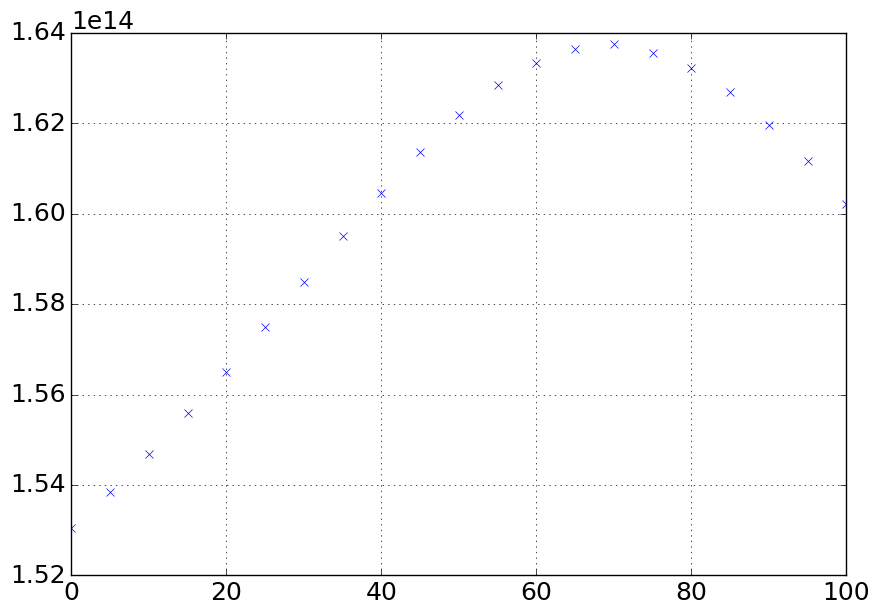

In [47]:
plt.figure(figsize=(10,7))
plt.plot(x,y,'x')
plt.grid(True)
plt.show()